In [1]:
%reload_ext autoreload
%autoreload 2

import mlflow.tracking
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from os import getcwd, listdir, makedirs
from os.path import join, isdir, dirname
import ast
from typing import Any
from argparse import ArgumentParser
from glob import glob
from IPython.display import display

sys.path.insert(0, join(getcwd(), "../module_code"))

import cli_utils 
import main
import exp.static_learning

sys.argv = [sys.argv[0]]
cli_utils.load_cli_args("../options.yml")
args = cli_utils.init_cli_args()

# path to mlflow directory (not mlruns)
mlflow_path = "/radraid/jeffreyfeng/CRRT_Project/mlflow/"

makedirs('./posthoc', exist_ok=True)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Helper functions

In [2]:
def get_client_from_id(mlflow_path, run):
    client_path = None
    for directory in listdir(mlflow_path):
        if 'mlruns' == directory:
            runs = glob(join(mlflow_path, directory,"*" ,run))
            if len(runs) > 0:
                client_path = join(mlflow_path, directory)
                break 
                    
        elif isdir(join(mlflow_path,directory)):
            runs = glob(join(mlflow_path, directory,'mlruns',"*" ,run))
            
            if len(runs) > 0:
                client_path = join(mlflow_path, directory, 'mlruns')
                break 
    
    return client_path

In [3]:
def better_search_runs(client, exp_path, filter):
    run_ = None
    filter = filter.split('and')
    
    for run in listdir(exp_path):
        run_path = join(exp_path,run)
    
        if 'trash' not in run and isdir(run_path):
        
            meets_criteria = 0
            for filt in filter:
                var = filt.split('tags.')[-1].split('=')[0]
                val = filt.split('=')[-1].strip('\'')
                with open(join(run_path,'tags',var), 'r') as f:
                    if f.read() == val:
                        meets_criteria+=1
            
            if meets_criteria == len(filter):
                run_ = client.get_run(run)
                break
    return run_

In [4]:
def get_run_from_name(mlflow_path, run_name, filter, from_id=False):
       
    if isdir(join(mlflow_path,run_name)):
        client_path = join(mlflow_path, run_name, 'mlruns')
    else:
        client_path = join(mlflow_path, 'mlruns')
        
    client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
    
    exp_path = join(client_path,client.get_experiment_by_name('static_learning').experiment_id)
    
    if from_id:
        run = client.get_run(run_name)
        return run, exp_path
    
    # run = client.search_runs(client.get_experiment_by_name('static_learning').experiment_id, 
    #                          filter_string=filter,
    #                         order_by=["attributes.start_time DESC"],
    # )[0]
    run = better_search_runs(client, exp_path, filter=filter)
        
    return run, exp_path 

In [5]:
def get_original_probabilities(exp_path, run_id, run_name, prefix):
    # get all probabilities                 
    predict_probas_path = join(exp_path, run_id, "artifacts", run_name, "predict_probas", f"{prefix}__{run_name}","predict_probas.pkl")
    predict_probas = pickle.load(open(predict_probas_path, 'rb'))
    
    # get all labels
    labels_path = join(exp_path, run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
    labels = pickle.load(open(labels_path, 'rb'))

    # align probabilities and labels
    try:
        aligned_df = pd.merge(predict_probas.to_frame(),labels.to_frame(),how='inner', on=['IP_PATIENT_ID','Start Date'])
    except:
        aligned_df = pd.merge(predict_probas,labels,how='inner', on=['IP_PATIENT_ID','Start Date'])
    labels = aligned_df['recommend_crrt']
    pred_probas = aligned_df[0].values
    
    return aligned_df, labels, pred_probas
                    

In [6]:
def get_control_probabilities(exp_path, run, run_name, prefix, slide=0):

    # assumes run is from control
    control_prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                        
    # GET THIS FOR UCLA 
    if 'ucla' in run_name:
        if slide == 0:
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")
        else:
            # run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name}' and tags.slide_window_by='{slide}'")
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: {slide}'")
    else:
        if slide == 0:
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt best'")
        else:
            # run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name}' and tags.slide_window_by='{slide}'")
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt rolling window: {slide}'")
    ucla_prob_df, _, _ = get_original_probabilities(exp_path, ucla_run.info.run_id, run_name, prefix)
    
    #CONCATENATE
    total = pd.concat([control_prob_df, ucla_prob_df])

    labels = total['recommend_crrt']
    pred_probas = total[0].values
                
    return labels, pred_probas

In [7]:
from evaluate.utils import eval_metric

def get_point_estimate(boostrap_mean, labels, pred_probas, metric_name, metric_fn, bootstrap_point=True):
    
    if bootstrap_point:
        point_estimate = boostrap_mean
    else:
        point_estimate = eval_metric(labels, pred_probas, metric_name, metric_fn, decision_threshold=0.5)
        
    return point_estimate

# Experiment grid

In [8]:
# Experiment grid
TRIALS=5
ucla_train=f'ucla_to_ucla_tune{TRIALS}'
cedars_train=f'cedars_to_cedars_tune{TRIALS}'
uclapluscedars_train=f'uclapluscedars_to_uclapluscedars_tune{TRIALS}'
all_train=f'all_to_all_tune{TRIALS}'

ucla_preselectall=f'ucla_to_ucla_preselectall_tune{TRIALS}_v2'
ucla_preselectcrrt=f'ucla_to_ucla_preselectcrrt_tune{TRIALS}'
cedars_preselectall=f'cedars_to_cedars_preselectall_tune{TRIALS}_v2'
cedars_preselectcrrt=f'cedars_to_cedars_preselectcrrt_tune{TRIALS}'
uclapluscedars_preselectall=f'uclapluscedars_to_uclapluscedars_preselectall_tune{TRIALS}_v2'
uclapluscedars_preselectcrrt=f'uclapluscedars_to_uclapluscedars_preselectcrrt_tune{TRIALS}'
all_preselectall=f'all_to_all_preselectall_tune{TRIALS}_v2'

In [9]:
from data.load import load_outcomes

OUTCOMES_CEDARS = load_outcomes(args.cedars_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])
OUTCOMES_UCLA = load_outcomes(args.ucla_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])

UCLA_IDS = OUTCOMES_UCLA.index.get_level_values('IP_PATIENT_ID')
CEDARS_IDS = OUTCOMES_CEDARS.index.get_level_values('IP_PATIENT_ID')

mealy | INFO - *****Loading Outcomes...*****


mealy | INFO - *****Loading Outcomes...*****


# Run post-hoc evaluation

Given any evaluation run, rerun evaluation. Can set new options such as:
1. Running rolling window if it wasn't done before
2. Running with explanations if it wasn't done before 

In [ ]:
def get_best_run(run_name):
    
    run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")
    
    try:
        best_run_id = run.data.tags['best_run_id']
    except:
        best_run_id = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
    
    best_run = get_run_from_name(mlflow_path, best_run_id, None, from_id=True)
    
    return best_run

def reinit_param_from_string(args: ArgumentParser, param_name:str, param_val: Any) -> Any:
    if param_val == "None":
        return None
    elif param_name in args.__dict__.keys():
        if type(args.__dict__[param_name]) in [int, str, float]:
            return type(args.__dict__[param_name])(param_val)
        else:
            return ast.literal_eval(param_val)
    else:
        return param_val

In [ ]:
def load_and_run_evaluation(run, eval_cohort):
    # Update with best params and with the run id.
    best_model_path = main.get_mlflow_model_uri(run)
    modeln = run.data.tags["modeln"]

    # split the best params into the ones that should be in model_kwargs and not
    top_level_params = {}
    model_kwargs = {}
    for param_name, param_val in run.data.tags.items():
        if param_name.startswith(modeln):
            # exclude the rf_ if modeln is rf
            raw_name = param_name[len(f"{args.modeln}") :]
            model_kwargs[raw_name] = param_val
        elif param_name.startswith('mlflow'):
            pass
        else:
            top_level_params[param_name] = reinit_param_from_string(args, param_name, param_val)
    model_kwargs.update(run.data.params)

    dargs = vars(args)
    dargs.update(
        {
            **top_level_params,
            # modeln is selected outside of optuna so it wont be in params
            "modeln": modeln,
            # model_kwargs in best_trial.params but flattened out
            # "model_kwargs": model_kwargs,
            # "best_run_id": run.info.run_id,
            "best_model_path": best_model_path,
            "stage": "eval",
            "rolling_evaluation": True,
            "reference_window": True,
            "plot_names": [],  # ["shap_explain", "randomness", "error_viz"],
            "slide_window_by": 0,
            "tune_n_trials": 0,
            
            # remove for explanation run
            "new_eval_cohort": True,
            "max_days_on_crrt": 200,
            "min_days_on_crrt": 8,
            "eval_cohort": eval_cohort if eval_cohort is not None else args.eval_cohort,
        }
    )
    
    # run
    main.run_experiment(args)

def rerun_evaluation(run_name, eval_cohort=None):
    best_run = get_best_run(run_name)
    load_and_run_evaluation(best_run, eval_cohort=eval_cohort)

In [ ]:
# Explanations for main 
eval_cohorts = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
            'ucla_crrt',
            'cedars_crrt',
            'ucla_control',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt+ucla_control',
            "ucla_crrt",
            "cedars_crrt",
            "ucla_control",
            "ucla_crrt",
            "cedars_crrt",
            'cedars_crrt',
            'ucla_crrt',
            'ucla_control',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt+ucla_control'
            ]

for run, eval_cohort in zip(runs, eval_cohorts):
    rerun_evaluation(run, eval_cohort)

In [ ]:
# Explanations for main 
rerun_evaluation(all_preselectall)

In [ ]:
# dargs.update(
#         {
#             "rolling_evaluation": True,
#             "reference_window": False,
#         }
#     )

#################### only limit 7 days
# windows = [(0,7)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})
#     main.run_experiment(args)

#################### slide forward
# num_days_to_slide = 7
# for i in range(1,num_days_to_slide):
#     dargs.update({"slide_window_by": i})
#     main.run_experiment(args)

#################### slide backward
# num_days_to_slide = 3
# for i in range(1,num_days_to_slide+1):
#     dargs.update({"slide_window_by": -i})
#     main.run_experiment(args)

#################### multiple windows and slides
# num_days_to_slide = 7
# windows = [(0,7),(8,14), (15,200)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})

#     for i in range(0,num_days_to_slide):
#         dargs.update({"slide_window_by": i})
#         main.run_experiment(args)

# Main metric curves

In [20]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm

def plot_metrics(curve_names, curve_fns, curve_params, 
                 runs, filters, plt_labels, 
                 subgroups, subgroup_labels, colors,
                 bootstrap_point=True):
    
    # For each type of curve (roc, pr, calibration)
    for curve_name, curve, curve_param in zip(
            curve_names,
            curve_fns,
            curve_params
        ):
            
            # metric associated with the curve
            metric_name = curve_param['metric']
            metric_fn = METRIC_MAP[metric_name]

            # track for multiple curves
            x_axis_values = []
            y_axis_values = []
            legend = []

            # iterate through different experiments
            for i in range(len(runs)):
                
                # get run
                if len(filters[i]) > 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[i], filter=f"tags.mlflow.runName='{runs[i]} // post_eval_{filters[i]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[i], filter=f"tags.mlflow.runName='{runs[i]} // eval best'")
                
                # iterate through subgroups within an experiment
                for j in range(len(subgroups)):
                    
                    # tag for filename
                    prefix = f"{run.data.tags['modeln']}_test{subgroups[j]}"

                    if 'control' not in filters[i]:
                        _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[i], prefix)

                        # get curve
                        figure = curve.from_predictions(labels.values, pred_probas)
                        
                        # obtain the data from curve
                        x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                        # save the data in a larger list
                        x_axis_values.append(x_axis)
                        y_axis_values.append(y_axis)
                        
                        # save legend in a list
                        metrics = run.data.metrics
                        point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)                       
                        legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f}"
                        legend.append(legend_txt.strip())
                        plt.close()
                        
                        if 'plus' in runs[i] or 'all_to_all' in runs[i]:
                            prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[i], prefix)
                            
                            # ISOLATE UCLA
                            ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                            labels = ucla_prob_df['recommend_crrt']
                            pred_probas = ucla_prob_df[0].values
                            
                            figure = curve.from_predictions(labels.values, pred_probas)
                            x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                            # save the data in a larger list
                            x_axis_values.append(x_axis)
                            y_axis_values.append(y_axis)
                            
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)                            
                            legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} UCLA_CRRT ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f}"
                            legend.append(legend_txt.strip())
                            plt.close()
                        
                            
                            # ISOLATE CEDARS
                            cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                            labels = cedars_prob_df['recommend_crrt']
                            pred_probas = cedars_prob_df[0].values
                            figure = curve.from_predictions(labels.values, pred_probas)
                            x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                            # save the data in a larger list
                            x_axis_values.append(x_axis)
                            y_axis_values.append(y_axis)
                            
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} CEDARS_CRRT ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f}"
                            legend.append(legend_txt.strip())
                            plt.close()
                        
                    else:
                        # GET THE CONTROL
                        labels, pred_probas = get_control_probabilities(exp_path, run, runs[i], prefix)

                        # get curve
                        figure = curve.from_predictions(labels.values, pred_probas)
                        
                        # obtain the data from curve
                        x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                        # save the data in a larger list
                        x_axis_values.append(x_axis)
                        y_axis_values.append(y_axis)
                        
                        # GET METRIC
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                        legend.append(legend_txt.strip())
                        plt.close()
                
            # create empty canvas for curves
            figure = curve.from_predictions(labels, pred_probas, pos_label=1)
            for artist in plt.gca().lines + plt.gca().collections:
                artist.remove()
            name = f"test_{subgroup_labels[j]}_{curve_name}"
            print(name)

            # add straight line 
            if "calibration_curve" in curve_name:
                legend.insert(0, 'Perfect Classifier')
                figure.ax_.plot([0, 1], [0, 1], ":k")

            # plot all curves on canvas
            for i in range(len(x_axis_values)):
                figure.ax_.plot(x_axis_values[i], y_axis_values[i], color=colors[i])
            
            # add in legend
            if len(x_axis_values)> 2:
                figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(0.55, 0.75),)
            else:
                if 'pr_curve' in curve_name:
                    figure.ax_.legend(legend,loc="upper right")
                else:
                    figure.ax_.legend(legend,loc="lower right")
                
            # save figure
            fig = plt.gcf()
            fig.set_size_inches(3.75, 3.75)
            plt.savefig(f'./posthoc/{name}.svg', format='svg',  bbox_inches="tight")

### Train on UCLA

test__calibration_curve
test__roc_curve
test__pr_curve
test_Infection_calibration_curve
test_Infection_roc_curve
test_Infection_pr_curve


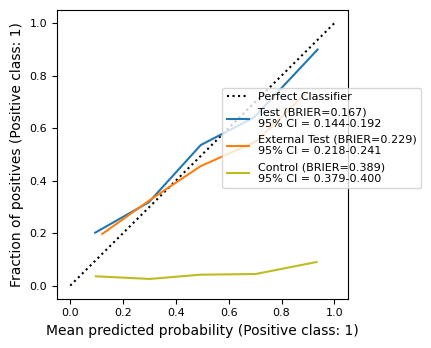

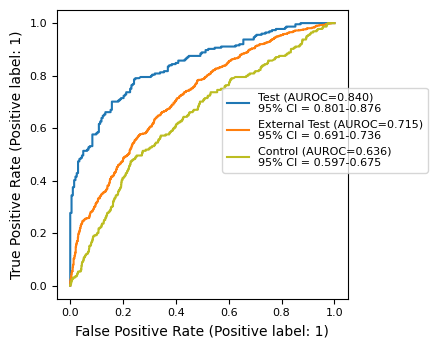

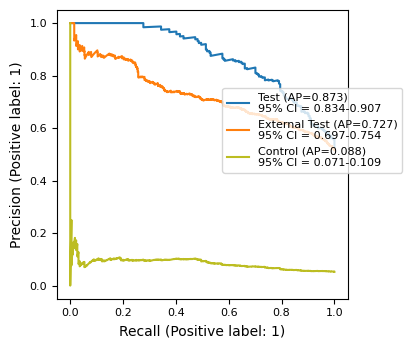

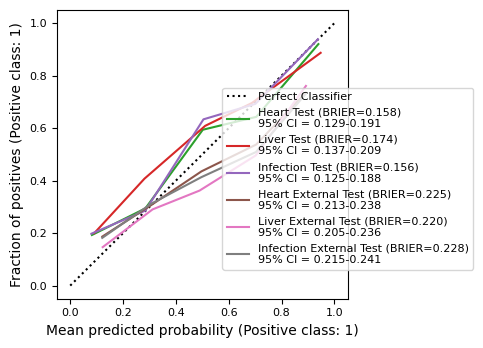

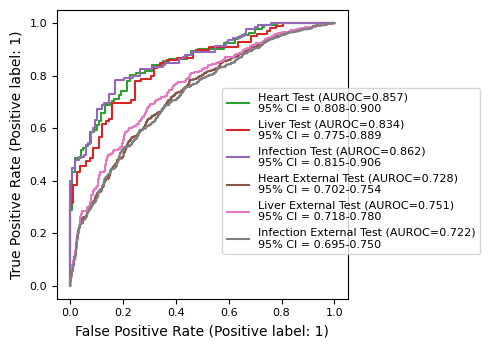

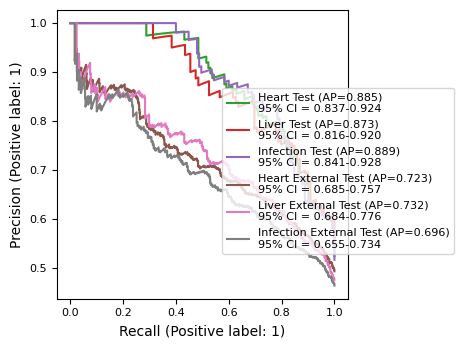

In [25]:
from models.static_models import CURVE_MAP

CURVE_PARAMS = {
    "calibration_curve": {
        "labels": ("prob_pred", "prob_true"),
        "limits": None,
        "metric": "brier",
    },
    "roc_curve": {"labels": ("fpr", "tpr"), "limits": (0, 1), "metric": "auroc"},
    "pr_curve": {"labels": ("recall", "precision"), "limits": None, "metric": "ap"},
    "det_curve": {"labels": ("fpr", "fnr"), "limits": None, "metric": "accuracy"},
}
curve_names = args.curve_names
curve_fns = [CURVE_MAP[metric] for metric in curve_names]
curve_params = [CURVE_PARAMS[metric] for metric in curve_names]

plt_labels = ['Test', "External Test", "Control"]
runs = [ucla_train, ucla_train, ucla_train]
filters = ['', 'cedars_crrt','ucla_control']

subgroups = [""]
subgroup_labels = [""]
colors = ['tab:blue', 'tab:orange', 'tab:olive', 'tab:green', 'tab:red', 'tab:purple']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

plt_labels = ['Test', "External Test"]
runs = [ucla_train, ucla_train]
filters = ['', 'cedars_crrt']
subgroups = ["_heart", "_liver", "_infection"]
subgroup_labels = ["Heart", "Liver", "Infection"]
colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

### Train on Cedars

test__calibration_curve
test__roc_curve
test__pr_curve
test_Infection_calibration_curve
test_Infection_roc_curve
test_Infection_pr_curve


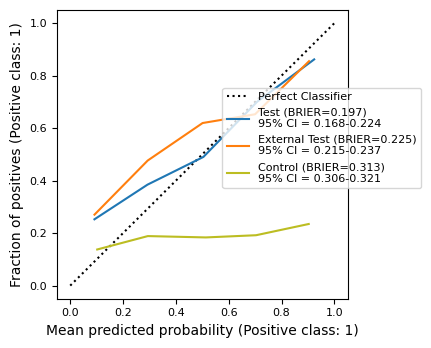

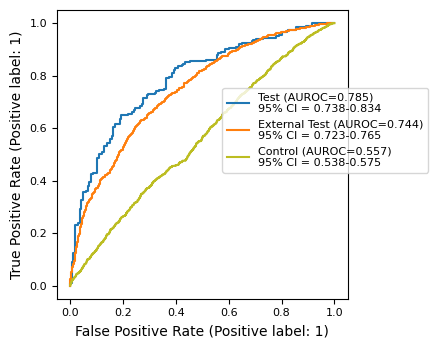

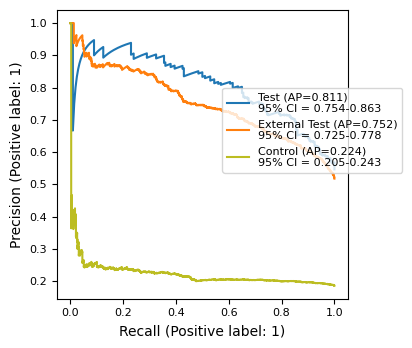

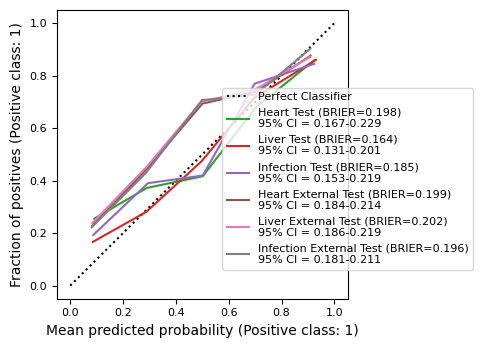

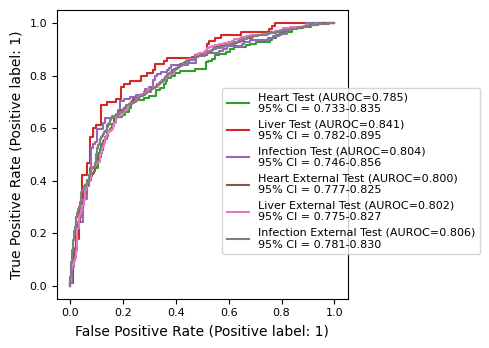

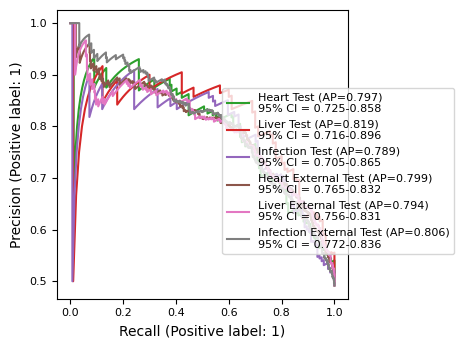

In [41]:
plt_labels = ['Test', "External Test", "Control"]
runs = [cedars_train, cedars_train, cedars_train]
filters = ['', 'ucla_crrt','ucla_control']
subgroups = [""]
subgroup_labels = [""]
colors = ['tab:blue', 'tab:orange','tab:olive']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors)

plt_labels = ['Test', "External Test"]
runs = [cedars_train, cedars_train]
filters = ['', 'ucla_crrt']
subgroups = ["_heart", "_liver", "_infection"]
subgroup_labels = ["Heart", "Liver", "Infection"]
colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors)

# Subgroups

## Helper functions

In [10]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm
from collections import defaultdict

def subgroup_tables(metric_names,
                    runs, filters,
                    subgroups, subgroup_labels,
                    bootstrap_point=True):
    
    for run,filter in zip(runs, filters):
        table = get_subgroup_table(metric_names, run, filter, subgroups, subgroup_labels, bootstrap_point=bootstrap_point)
        display(pd.DataFrame(table))
        
def get_subgroup_table(metric_names, 
              run_name, filter,
              subgroups, subgroup_labels, 
              bootstrap_point=True):
    
    table = {'counts': {}}

    if len(filter) > 0:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

    metrics = run.data.metrics

    for metric_name in tqdm(metric_names):
        
        metric_fn = METRIC_MAP[metric_name]
        table[metric_name] = {}
        
        for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
            
            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if 'control' not in filter:
                if f"{prefix}__{metric_name}" in metrics.keys() and (metrics[prefix+'__'+metric_name]==metrics[prefix+'__'+metric_name]):
                    _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                    
                    point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                    
                    ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                    ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                    table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    
                    if len(labels.value_counts()) > 1:
                        table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    else:
                        table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                else:
                    try:
                        _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        if len(labels.value_counts()) > 1:
                            table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                        else:
                            table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                    except:
                        
                        table[metric_name][subgroup_label] = "0.0 (0.0-0.0)"
                        table['counts'][subgroup_label] = "0 (0%)"
                    
                if 'plus' in run_name or 'all_to_all' in run_name:                    
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    pred_probas = ucla_prob_df[0].values
                    
                    try:
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        table[metric_name][f"{subgroup_label} ucla_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                        
                        if len(labels.value_counts()) > 1:
                            table['counts'][f"{subgroup_label} ucla_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                        else:
                            table['counts'][f"{subgroup_label} ucla_crrt"] = f"{len(labels)} (0%)"
                    except:
                        table[metric_name][f"{subgroup_label} ucla_crrt"] = "0.0 (0.0-0.0)"
                        table['counts'][f"{subgroup_label} ucla_crrt"] = "0 (0%)"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    pred_probas = cedars_prob_df[0].values
                    try:
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        table[metric_name][f"{subgroup_label} cedars_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                        if len(labels.value_counts()) > 1:
                            table['counts'][f"{subgroup_label} cedars_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                        else:
                            table['counts'][f"{subgroup_label} cedars_crrt"] = f"{len(labels)} (0%)"   
                    except:
                        table[metric_name][f"{subgroup_label} cedars_crrt"] = "0.0 (0.0-0.0)"
                        table['counts'][f"{subgroup_label} cedars_crrt"] = "0 (0%)"
                                 
            else:
                # GET THE CONTROL
                try:
                    labels, pred_probas = get_control_probabilities(exp_path, run, run_name, prefix)
                    
                    # GET METRIC
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)

                    point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    if len(labels.value_counts()) > 1:
                        table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    else:
                        table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                except:
                    table[metric_name][subgroup_label] = "0.0 (0.0-0.0)"
                    table['counts'][subgroup_label] = "0 (0%)"
    
    with open(f'./posthoc/{run_name}_{filter}_subgroups.pkl', 'wb') as f:
        pickle.dump(table,f)    
    return table

def report_as_is(metric_names,
                    runs, filters,
                    subgroup_labels,):
    
    metric_table = {}
    for metric_name in metric_names:
        
        for run, filter in zip(runs, filters):
            metric_table[metric_name] = {}
            
            with open(f'./posthoc/{run}_{filter}_subgroups.pkl', 'rb') as f:
                table = pickle.load(f)
                
            for subgroup_label in subgroup_labels:
                metric_table[metric_name][subgroup_label] = table[metric_name][subgroup_label]
    
                if 'plus' in run or 'all_to_all' in run:
                    metric_table[metric_name][f'{subgroup_label} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    metric_table[metric_name][f'{subgroup_label} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    
    display(pd.DataFrame(metric_table))

def report_subgroup_metrics(metric_names,
                    runs, filters,
                    subgroup_labels,):
        
    for metric_name in metric_names:
        metric_table = {}
        
        for run, filter in zip(runs, filters):
            metric_table[f'{run} {filter}'] = {}
            
            with open(f'./posthoc/{run}_{filter}_subgroups.pkl', 'rb') as f:
                table = pickle.load(f)
                
            for subgroup_label in subgroup_labels:
                metric_table[f'{run} {filter}'][subgroup_label] = table[metric_name][subgroup_label]
    
                if 'plus' in run or 'all_to_all' in run:
                    metric_table[f'{run} {filter} ucla_crrt'][subgroup_label] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    metric_table[f'{run} {filter} cedars_crrt'][subgroup_label] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    
        display(pd.DataFrame(metric_table))
    
def plot_subgroup(metric_names,
                    runs, filters, plt_labels,
                    subgroup_labels, subgroup_categories):
    
    for metric_name in metric_names:
        metric_table = defaultdict(list)
        ci_low_table = defaultdict(list)
        ci_high_table = defaultdict(list)
        
        for run, filter in zip(runs, filters):         
            
            with open(f'./posthoc/{run}_{filter}_subgroups.pkl', 'rb') as f:
                table = pickle.load(f)
                
            for subgroup_label in subgroup_labels:
                metric_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split(' (')[0]))
                ci_low_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split('(')[-1].split('-')[0]))
                ci_high_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]))
    
                if 'plus' in run or 'all_to_all' in run:
                    metric_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0]))
                
                    metric_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
        for key_ in metric_table.keys():
            ci_low_table[key_] = np.absolute(np.array(metric_table[key_]) - np.array(ci_low_table[key_]))
            ci_high_table[key_] = np.absolute(np.array(ci_high_table[key_]) - np.array(metric_table[key_]))
            
        # organize subgroups into broader categories (eg. age, race)
        x = []
        category_x = []
        category_labels = []
        prev_category = None
        current_category = None
        index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
        for i in range(len(subgroup_labels)):
            current_category = subgroup_categories[i]
            if current_category != prev_category:
                category_x.append(index)
                category_labels.append(current_category)
                index -= 1
                prev_category = current_category
            x.append(index)
            index -= 1
        x = np.array(x)
        
        # plotting
        fig, ax = plt.subplots()
        width = 0.25
        multiplier = 0
        
        for i, key_ in enumerate(metric_table.keys()):
            
            offset = width * multiplier
            
            # Horizontal
            # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])
            # plt.errorbar(x + offset, grouped_metric_vals[i], yerr=[errors_low[i], errors_high[i]], marker="D", capsize=5, elinewidth=2,label=plt_labels[i])
            
            # Vertical
            plt.errorbar(metric_table[key_], x + offset, xerr=[ci_low_table[key_], ci_high_table[key_]], marker="D", capsize=3, elinewidth=1,label=plt_labels[i], linestyle='none')
            
            # Plot a vertical line for main value (metric on all patients)
            # ax.plot([0., x[-1]], [grouped_metric_vals[0][0], grouped_metric_vals[0][0]], "k--")
            # ax.plot([0., x[-1]], [grouped_metric_vals[1][0], grouped_metric_vals[1][0]], "k--")
            ax.plot([metric_table[key_][0], metric_table[key_][0]], [0., x[0]], "k--", linewidth=1)
            
            multiplier += 1
        
        # Subgroup category labels
        ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
        # Subgroup labels
        ax.set_yticks(x + width, subgroup_labels, minor=True)
        
        if metric_name not in ['TP', 'FP', 'TN', 'FN']:
            ax.set_xlim([0,1])
        ax.tick_params(axis='y', which='major', length=0)
        # plt.yticks(ha='left')
        # ax.set_title(name)
        ax.set_xlabel(metric_name.upper())
        ax.legend()
        
        # save figure
        name = f"{metric_name}_subgroup" 
        print(name)
        fig = plt.gcf()
        fig.set_size_inches(3, 10)
        plt.savefig(f'./posthoc/{name}_forestplot.svg', format='svg',  bbox_inches="tight")
                    

## Process subgroups

In [11]:
metric_names = args.metric_names + ['specificity']

runs = [
        ucla_train,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        # all_train
        ]
filters = [
            '',
        #     'cedars_crrt',
        #     'ucla_control',
            # '',
            # 'ucla_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_control',
            # ''
            ]

plt_labels = ['Test', "External Test", "Control"] # same len as runs

subgroups = [
              "", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
              '_female','_male', 
              '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
              '_Hispanic or Latino','_Not Hispanic or Latino',
              '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
              'race','race','race','race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

subgroup_tables(metric_names,
                runs, filters,
                subgroups, subgroup_labels,
                bootstrap_point=True)


In [39]:
runs = [
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        # ucla_preselectcrrt,
        # ucla_preselectcrrt,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectcrrt,
        # cedars_preselectcrrt,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectcrrt,
        # all_preselectall
]
filters = [
            "",
            "cedars_crrt",
            "ucla_control",
            # "",
            # "cedars_crrt",
            # '',
            # 'ucla_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_crrt',
            # '',
            # 'ucla_control',
            # '',
            # ''
            ]
plt_labels = ['Test', "External Test", "Control"] # same len as runs

subgroup_tables(metric_names
                runs, filters,
                subgroups, sub,group_labels)

## Plot subgroups

In [12]:
report_subgroup_metrics(['counts'],
                runs, filters,
                subgroup_labels)

# plot_subgroup(metric_names,
#                 runs, filters, plt_labels,
#                 subgroup_labels, subgroup_categories)

,ucla_to_ucla_tune5,ucla_to_ucla_tune5 cedars_crrt,ucla_to_ucla_tune5 ucla_control
all,427 (52.5%),1792 (51.6%),4260 (5.3%)
heart,252 (52.4%),1446 (49.3%),1772 (7.4%)
liver,181 (54.7%),950 (47.6%),1377 (7.2%)
infection,242 (51.7%),1270 (46.4%),1392 (9.0%)
"no heart,liver,\ninfection",139 (52.5%),229 (65.1%),2086 (3.5%)
female,184 (44.0%),666 (49.5%),1708 (4.7%)
male,243 (58.8%),1126 (52.8%),2552 (5.6%)
American Indian\nor Alaska Native,2 (0%),2 (0%),15 (0%)
Asian,30 (63.3%),144 (56.2%),355 (5.4%)
Black or African American,47 (57.4%),287 (49.5%),418 (6.5%)


# Rolling window

## Helper functions

In [19]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm
from collections import defaultdict

def rolling_count(runs, filters, slides):
    
    table = {}

    # get run
    for j in range(len(runs)):
        for k in tqdm(slides):
            
            if len(filters[j]) > 0:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} rolling window: {k}'")
            else:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")
                else:
                    # run, _ = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]}' and tags.slide_window_by='{k}'")
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // rolling window: {k}'")
                        
            if k not in table.keys():
                table[k] = {}
            
            prefix = f"{run.data.tags['modeln']}_test"
            
            if 'control' not in filters[j]:
                
                _, labels, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                table[k][f"{runs[j]} {filters[j]}"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    
                if 'plus' in runs[j] or 'all_to_all' in runs[j]:
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    table[k][f"{runs[j]} ucla_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    table[k][f"{runs[j]} cedars_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                             
            else:
                labels, _ = get_control_probabilities(exp_path, run, runs[j], prefix, slide=k)
                table[k][f"{runs[j]} {filters[j]}"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                
    return table

def rolling_tables(metric_names,
                    runs, filters, 
                     slides, 
                     subgroups,
                     bootstrap_point=True):

    for metric_name in metric_names:
        for subgroup in subgroups:
            table = get_rolling_table(metric_name, runs, filters, slides, subgroup=subgroup, bootstrap_point=bootstrap_point)
            display(pd.DataFrame(table))

def get_rolling_table(metric_name,
                     runs, filters, 
                     slides, 
                     subgroup="",
                     bootstrap_point=True):
    
    metric_fn = METRIC_MAP[metric_name]
    table = {}

    # get run
    for j in range(len(runs)):
        for k in tqdm(slides):
            
            if len(filters[j]) > 0:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} rolling window: {k}'")
            else:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")
                else:
                    # run, _ = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]}' and tags.slide_window_by='{k}'")
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // rolling window: {k}'")
                        
            if k not in table.keys():
                table[k] = {}
            
            metrics = run.data.metrics            
            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if 'control' not in filters[j]:
            
                if f"{prefix}__{metric_name}" in metrics.keys():
                    _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                    ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                    ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                    table[k][f"{runs[j]} {filters[j]}"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                else:
                    table[k][f"{runs[j]} {filters[j]}"] = "0.0 (0.0-0.0)"
                    
                if 'plus' in runs[j] or 'all_to_all' in runs[j]:
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    pred_probas = ucla_prob_df[0].values
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[k][f"{runs[j]} ucla_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    pred_probas = cedars_prob_df[0].values
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[k][f"{runs[j]} cedars_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                             
            else:
                # GET THE CONTROL
                # try:
                labels, pred_probas = get_control_probabilities(exp_path, run, runs[j], prefix, slide=k)
                
                # GET METRIC
                bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                point_estimate = get_point_estimate(bootstrapped_metrics.mean(), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                table[k][f"{runs[j]} {filters[j]}"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                # except:
                #     table[k][f"{runs[j]} {filters[j]}"] = "0.0 (0.0-0.0)"
        
    with open(f'./posthoc/{subgroup}{metric_name}_rolling.pkl', 'wb') as f:
        pickle.dump(table,f)    
        
    return table

def plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                subgroups, subgroup_labels,
                colors=None):
    
    for metric_name in metric_names:
                
        # Iterate through each subgroup
        for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
            
            metric_table = defaultdict(list)
            ci_low_table = defaultdict(list)
            ci_high_table = defaultdict(list)
            
            with open(f'./posthoc/{subgroup}{metric_name}_rolling.pkl', 'rb') as f:
                table = pickle.load(f)  
            
            for run, filter in zip(runs,filters):
                for k in slides:
                    metric_table[f"{run} {filter}"].append(float(table[k][f"{run} {filter}"].split(' (')[0]))                
                    ci_low_table[f'{run} {filter}'].append(float(table[k][f"{run} {filter}"].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter}'].append(float(table[k][f"{run} {filter}"].split('-')[-1].split(')')[0]))
    
                if 'plus' in run or 'all_to_all' in run:
                    metric_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split('-')[-1].split(')')[0]))
                
                    metric_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
            
            # difference between value and CI bounds
            for key_ in metric_table.keys():
                ci_low_table[key_] = np.array(metric_table[key_]) - np.array(ci_low_table[key_])
                ci_high_table[key_] = np.array(ci_high_table[key_]) - np.array(metric_table[key_])
                
            
            # plot combined plots
            fig, ax = plt.subplots()
            
            width = 0.1
            multiplier = 0
            
            x = np.arange(len(slides))

            for i, key_ in enumerate(metric_table.keys()):                
                offset = width * multiplier

                # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])

                if colors is not None:
                    plt.errorbar(x + offset, metric_table[key_], yerr=[ci_low_table[key_], ci_high_table[key_]], marker="d",linestyle='--', capsize=5, elinewidth=2,label=plt_labels[i], color=colors[i])
                else:
                    plt.errorbar(x + offset, metric_table[key_], yerr=[ci_low_table[key_], ci_high_table[key_]], marker="d",linestyle='--', capsize=5, elinewidth=2,label=plt_labels[i])
                
                multiplier += 1
            
            ax.set_xticks(x + width, slides)
            ax.set_ylabel(metric_name.upper())
            ax.set_xlabel('Days relative to start date')
            ax.set_ylim([0,1])
            ax.legend()
            
            # Save figures
            name = f"{metric_name}_{subgroup_label}"
            print(name)
            fig = plt.gcf()
            fig.set_size_inches(3, 3)
            plt.savefig(f'./posthoc/{name}_rolling.svg', format='svg',  bbox_inches="tight")

## Window counts

In [102]:
table = rolling_count([
                          ucla_train,
                          ucla_train,
                          ucla_train,
                          cedars_train,
                          cedars_train,
                          cedars_train,
                          uclapluscedars_train,
                          uclapluscedars_train,
                          all_train
                          ], 
                         [
                          '',
                          'cedars_crrt',
                          'ucla_control',
                          '',
                          'ucla_crrt',
                          'ucla_control',
                          '',
                          'ucla_control',
                          ''
                          ],
                         [-3,-2,-1,0,1,2,3,4,5,6])
display(pd.DataFrame(table))

table = rolling_count([ucla_preselectall,
                          ucla_preselectall,
                          ucla_preselectall,
                          ucla_preselectcrrt,
                          ucla_preselectcrrt,
                          cedars_preselectall,
                          cedars_preselectall,
                          cedars_preselectall,
                          cedars_preselectcrrt,
                          cedars_preselectcrrt,
                          uclapluscedars_preselectall,
                          uclapluscedars_preselectall,
                          uclapluscedars_preselectcrrt,
                          all_preselectall],
                         ["",
                          "cedars_crrt",
                          "ucla_control",
                          "",
                          "cedars_crrt",
                          '',
                          'ucla_crrt',
                          'ucla_control',
                          '',
                          'ucla_crrt',
                          '',
                          'ucla_control',
                          '',
                          ''],
                         [-3,-2,-1,0,1,2,3,4,5,6])
display(pd.DataFrame(table))

100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


,-3,-2,-1,0,1,2,3,4,5,6
ucla_to_ucla_tune5,335 (54.9%),347 (54.8%),366 (54.4%),427 (52.5%),361 (58.2%),284 (62.0%),199 (61.8%),125 (56.0%),87 (56.3%),34 (55.9%)
ucla_to_ucla_tune5 cedars_crrt,1104 (53.0%),1238 (53.1%),1429 (52.3%),1792 (51.6%),1563 (56.5%),1210 (62.1%),873 (64.5%),574 (63.4%),374 (64.2%),160 (61.9%)
ucla_to_ucla_tune5 ucla_control,3269 (5.6%),3371 (5.6%),3547 (5.6%),4260 (5.3%),4194 (5.0%),4117 (4.3%),4032 (3.1%),3958 (1.8%),3920 (1.2%),3867 (0.5%)
cedars_to_cedars_tune5,224 (54.9%),251 (56.6%),291 (56.0%),366 (54.6%),317 (59.0%),247 (64.8%),180 (68.9%),120 (67.5%),82 (64.6%),36 (52.8%)
cedars_to_cedars_tune5 ucla_crrt,1701 (53.4%),1775 (53.2%),1881 (53.2%),2148 (51.8%),1780 (57.0%),1374 (60.8%),1012 (61.1%),652 (61.3%),388 (60.6%),181 (58.6%)
cedars_to_cedars_tune5 ucla_control,4635 (19.6%),4799 (19.7%),5062 (19.8%),5981 (18.6%),5613 (18.1%),5207 (16.1%),4845 (12.8%),4485 (8.9%),4221 (5.6%),4014 (2.6%)
uclapluscedars_to_uclapluscedars_tune5,578 (54.3%),618 (53.6%),673 (52.9%),794 (52.0%),677 (57.8%),514 (63.4%),384 (64.6%),250 (61.6%),135 (65.2%),66 (65.2%)
uclapluscedars_to_uclapluscedars_tune5 ucla_crrt,364 (53.8%),371 (53.1%),383 (53.3%),426 (51.9%),350 (58.3%),271 (62.0%),205 (61.0%),136 (57.4%),64 (59.4%),33 (54.5%)
uclapluscedars_to_uclapluscedars_tune5 cedars_crrt,214 (55.1%),247 (54.3%),290 (52.4%),368 (52.2%),327 (57.2%),243 (65.0%),179 (68.7%),114 (66.7%),71 (70.4%),33 (75.8%)
uclapluscedars_to_uclapluscedars_tune5 ucla_control,3512 (8.9%),3642 (9.1%),3854 (9.2%),4627 (8.9%),4510 (8.7%),4347 (7.5%),4217 (5.9%),4083 (3.8%),3968 (2.2%),3899 (1.1%)


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


,-3,-2,-1,0,1,2,3,4,5,6
ucla_to_ucla_preselectall_tune5,274 (53.3%),284 (53.2%),327 (54.4%),410 (52.7%),350 (57.7%),278 (62.6%),210 (62.4%),152 (61.8%),96 (62.5%),45 (71.1%)
ucla_to_ucla_preselectall_tune5 cedars_crrt,1044 (53.5%),1181 (53.5%),1373 (52.6%),1774 (51.8%),1547 (56.8%),1197 (62.4%),864 (64.8%),567 (63.8%),369 (64.5%),157 (62.4%)
ucla_to_ucla_preselectall_tune5 ucla_control,2016 (7.2%),2166 (7.0%),2400 (7.4%),3405 (6.3%),3345 (6.0%),2760 (6.3%),2452 (5.3%),2267 (4.1%),2083 (2.9%),1933 (1.7%)
ucla_to_ucla_preselectcrrt_tune5,335 (54.9%),347 (54.8%),366 (54.4%),427 (52.5%),361 (58.2%),284 (62.0%),199 (61.8%),125 (56.0%),87 (56.3%),34 (55.9%)
ucla_to_ucla_preselectcrrt_tune5 cedars_crrt,1104 (53.0%),1238 (53.1%),1429 (52.3%),1792 (51.6%),1563 (56.5%),1210 (62.1%),873 (64.5%),574 (63.4%),374 (64.2%),160 (61.9%)
cedars_to_cedars_preselectall_tune5,224 (54.9%),251 (56.6%),291 (56.0%),366 (54.6%),317 (59.0%),247 (64.8%),180 (68.9%),120 (67.5%),82 (64.6%),36 (52.8%)
cedars_to_cedars_preselectall_tune5 ucla_crrt,1701 (53.4%),1775 (53.2%),1881 (53.2%),2148 (51.8%),1780 (57.0%),1374 (60.8%),1012 (61.1%),652 (61.3%),388 (60.6%),181 (58.6%)
cedars_to_cedars_preselectall_tune5 ucla_control,4635 (19.6%),4799 (19.7%),5062 (19.8%),5981 (18.6%),5613 (18.1%),5207 (16.1%),4845 (12.8%),4485 (8.9%),4221 (5.6%),4014 (2.6%)
cedars_to_cedars_preselectcrrt_tune5,224 (54.9%),251 (56.6%),291 (56.0%),366 (54.6%),317 (59.0%),247 (64.8%),180 (68.9%),120 (67.5%),82 (64.6%),36 (52.8%)
cedars_to_cedars_preselectcrrt_tune5 ucla_crrt,1701 (53.4%),1775 (53.2%),1881 (53.2%),2148 (51.8%),1780 (57.0%),1374 (60.8%),1012 (61.1%),652 (61.3%),388 (60.6%),181 (58.6%)


## Process windows

In [11]:

metric_names = ['auroc','ap']
runs = [
        ucla_train,
        ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        # all_train
        ]
filters = [
        '',
        'cedars_crrt',
        # 'ucla_control',
        # '',
        # 'ucla_crrt',
        # 'ucla_control',
        # '',
        # 'ucla_control',
        # ''
        ]
slides = [-3,-2,-1,0,1,2,3,4,5,6]
subgroups =  [""]
subgroup_labels = ["all"]
# subgroups = ["", "_heart"]
plt_labels = ["Test", "External test"]

rolling_tables(metric_names,
                runs, filters, 
                slides, 
                subgroups,
                bootstrap_point=True)
                    

100%|██████████| 10/10 [04:00<00:00, 24.06s/it]


,-3,-2,-1,0,1,2,3,4,5,6
ucla_to_ucla_tune5,0.75 (0.70-0.80),0.78 (0.73-0.83),0.79 (0.75-0.84),0.84 (0.80-0.88),0.86 (0.83-0.90),0.86 (0.82-0.90),0.87 (0.82-0.91),0.89 (0.82-0.94),0.91 (0.84-0.97),0.98 (0.93-1.00)
ucla_to_ucla_tune5 cedars_crrt,0.68 (0.65-0.71),0.68 (0.65-0.71),0.71 (0.68-0.73),0.71 (0.69-0.74),0.71 (0.69-0.74),0.70 (0.67-0.73),0.69 (0.65-0.72),0.70 (0.66-0.75),0.70 (0.64-0.76),0.67 (0.58-0.76)


100%|██████████| 10/10 [04:48<00:00, 28.82s/it]


,-3,-2,-1,0,1,2,3,4,5,6
ucla_to_ucla_tune5,0.80 (0.74-0.85),0.83 (0.78-0.87),0.84 (0.79-0.88),0.87 (0.83-0.91),0.91 (0.88-0.93),0.92 (0.89-0.95),0.93 (0.89-0.96),0.93 (0.88-0.97),0.95 (0.90-0.98),0.98 (0.94-1.00)
ucla_to_ucla_tune5 cedars_crrt,0.70 (0.66-0.75),0.71 (0.68-0.75),0.73 (0.70-0.76),0.73 (0.70-0.75),0.76 (0.73-0.79),0.79 (0.76-0.82),0.79 (0.75-0.83),0.78 (0.73-0.83),0.78 (0.72-0.84),0.74 (0.64-0.84)


In [22]:
metric_names = ['auroc','ap']

runs = [
        ucla_preselectall,
            ucla_preselectall,
            ucla_preselectall,
            # ucla_preselectcrrt,
            # ucla_preselectcrrt,
            # cedars_preselectall,
            # cedars_preselectall,
            # cedars_preselectall,
            # cedars_preselectcrrt,
            # cedars_preselectcrrt,
            # uclapluscedars_preselectall,
            # uclapluscedars_preselectall,
            # uclapluscedars_preselectcrrt,
            # all_preselectall
            ]
filters = [
            "",
            "cedars_crrt",
            "ucla_control",
            # "",
            # "cedars_crrt",
            # '',
            # 'ucla_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_crrt',
            # '',
            # 'ucla_control',
            # '',
            # ''
            ]
slides = [-3,-2,-1,0,1,2,3,4,5,6]
subgroups =  [""]
subgroup_labels = ["all"]
rolling_tables(metric_names,
                runs, filters, 
                slides, 
                subgroups,
                bootstrap_point=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


,-3,-2,-1,0,1,2,3,4,5,6
ucla_to_ucla_preselectall_tune5_v2,0.56 (0.49-0.63),0.61 (0.54-0.67),0.63 (0.57-0.69),0.70 (0.65-0.75),0.68 (0.62-0.73),0.64 (0.57-0.71),0.67 (0.59-0.74),0.67 (0.58-0.75),0.64 (0.52-0.76),0.80 (0.60-0.94)
ucla_to_ucla_preselectall_tune5_v2 cedars_crrt,0.61 (0.57-0.64),0.59 (0.56-0.62),0.62 (0.59-0.65),0.62 (0.59-0.64),0.60 (0.57-0.63),0.58 (0.55-0.62),0.58 (0.54-0.62),0.57 (0.52-0.62),0.60 (0.55-0.66),0.58 (0.49-0.68)
ucla_to_ucla_preselectall_tune5_v2 ucla_control,0.51 (0.47-0.55),0.54 (0.50-0.59),0.56 (0.52-0.60),0.59 (0.55-0.63),0.55 (0.51-0.59),0.52 (0.48-0.57),0.55 (0.51-0.60),0.56 (0.50-0.62),0.58 (0.51-0.65),0.59 (0.50-0.68)


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


,-3,-2,-1,0,1,2,3,4,5,6
ucla_to_ucla_preselectall_tune5_v2,0.59 (0.51-0.68),0.67 (0.58-0.74),0.68 (0.60-0.75),0.75 (0.68-0.81),0.74 (0.68-0.81),0.75 (0.68-0.82),0.78 (0.71-0.85),0.79 (0.70-0.86),0.78 (0.67-0.87),0.88 (0.74-0.99)
ucla_to_ucla_preselectall_tune5_v2 cedars_crrt,0.64 (0.60-0.68),0.61 (0.57-0.65),0.62 (0.58-0.66),0.62 (0.58-0.65),0.65 (0.61-0.69),0.70 (0.66-0.73),0.71 (0.67-0.75),0.70 (0.64-0.75),0.73 (0.67-0.80),0.71 (0.61-0.80)
ucla_to_ucla_preselectall_tune5_v2 ucla_control,0.07 (0.06-0.09),0.08 (0.07-0.11),0.09 (0.07-0.11),0.09 (0.07-0.10),0.07 (0.06-0.08),0.07 (0.05-0.08),0.06 (0.05-0.08),0.05 (0.04-0.07),0.04 (0.03-0.05),0.02 (0.01-0.03)


## Plot rolling windows

auroc_all
ap_all


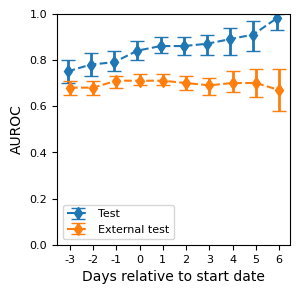

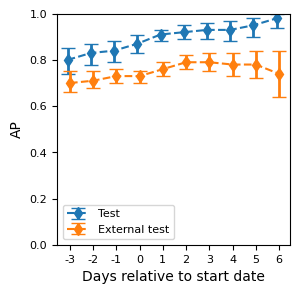

In [21]:
plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                subgroups,subgroup_labels = ["all"])

# Clinical impact

In [68]:
from sklearn.metrics import auc, det_curve, confusion_matrix

def get_cost(prob_df, threshold, price=True):
    
    prices = [543, 3486*0.76/7, 5177*0.76/7, 276.70*1.11, 2607*0.76/7,3089*0.76/7,436*1.11, 3629.80, 1100*0.76, 3700*0.76]
    
    # GET FN AND TN patients 
    # labels = prob_df['recommend_crrt']
    # pred_probas = prob_df[0].values
    prob_df['pred'] = (prob_df[0] >= threshold).astype(int)
    prob_df['N'] = (prob_df['pred']==0).astype(int)
    
    # GET CRRT_TOTAL_DAYS for the selected patients
    days = pd.merge(prob_df, pd.concat([OUTCOMES_UCLA, OUTCOMES_CEDARS]), how='left', on=['IP_PATIENT_ID','Start Date'])
    days = days[days['N']==1]
    
    # sum total days
    total_days_saved = days['CRRT Total Days'].sum()
    
    # multuply by cost
    if price:
        return total_days_saved*np.mean(prices)
    else:
        return total_days_saved

def plot_clinical_impact(metric_names, metric_fns, 
                         runs, filters, plt_labels, 
                         subgroups, subgroup_labels, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True):

    for i in range(len(subgroups)):
        print(subgroups[i])

        for j in range(len(runs)):
            
            if len(filters[j]) > 0:
                run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
            else:
                run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")

            prefix = f"{run.data.tags['modeln']}_test{subgroups[i]}"
            
            prob_df, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)

            grouping_labels = ['Current\nStandard', 'Clinical ML\nFN=0','Clinical ML\nFN=2','Clinical ML\nThresh=0.5']
            
            conf_matrix_values = {metric: [] for metric in metric_names}
            
            savings = [None]
            
            # Current clinical practice
            for metric_name, metric_fn in zip(metric_names,metric_fns):
                conf_matrix_values[metric_name].append(metric_fn(labels, labels, 0.5))
            conf_matrix_values['FP'] = conf_matrix_values['TN']
            conf_matrix_values['TN'] = [0]
            
            # Search for good threshold (FN=0 or FN=2)
            fpr, fnr, thresholds = det_curve(labels, pred_probas)
            use_thresh = []
            for threshold in thresholds:
                if confusion_matrix(labels, (pred_probas >= threshold).astype(int))[1, 0] == 0 \
                    or confusion_matrix(labels, (pred_probas >= threshold).astype(int))[1, 0] == 2:
                    use_thresh.append(threshold)
                if len(use_thresh) == len(grouping_labels)-2:
                    break
            for k in range(1,len(grouping_labels)-1):
                for metric_name, metric_fn in zip(metric_names,metric_fns):
                    conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, use_thresh[k-1]))
                    savings.append(get_cost(prob_df, use_thresh[k-1], price))

            # Decision threshold = 0.5
            for metric_name, metric_fn in zip(metric_names,metric_fns):
                conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, 0.5))
                savings.append(get_cost(prob_df, 0.5, price))
            
            fig, ax = plt.subplots()
            bottom = np.zeros(len(grouping_labels)-1)
            bottom_baseline = 0

            for k, metric_name in enumerate(metric_names):
                data = conf_matrix_values[metric_name]
                if data[0] > 0:
                    p = ax.bar(grouping_labels[0], data[0], 0.5, label=conf_matrix_baseline_label[k], bottom=bottom_baseline, edgecolor='black',linestyle='--',color=colors[k], alpha=0.5)
                    bottom_baseline += data[0]
                    labels = [int(v) if v > 2 else "" for v in p.datavalues]    
                    ax.bar_label(p, labels=labels, label_type="center")

            for k, metric_name in enumerate(metric_names):
                p = ax.bar(grouping_labels[1:], conf_matrix_values[metric_name][1:], 0.5, label=conf_matrix_label[k], bottom=bottom, color=colors[k])
                bottom += conf_matrix_values[metric_name][1:]

                labels = [int(v) if v > 2 else "" for v in p.datavalues]    
                ax.bar_label(p, labels=labels, label_type="center")

            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            if price:
                ax2.set_ylabel('Total cost savings ($)', color='m')  # we already handled the x-label with ax1
            else:
                ax2.set_ylabel('Total CRRT days saved', color='m')  # we already handled the x-label with ax1
                   
            ax2.errorbar(grouping_labels, savings, color='m')
            # ax2.errorbar(grouping_labels, [None]+list(savings*np.max(prices)), color='tab:green', linestyle='--')
            # ax2.errorbar(grouping_labels, [None]+list(savings*np.min(prices)), color='tab:green', linestyle='--')
            ax2.set_ylim([0, np.max(savings)+0.1*np.max(savings)])
            ax2.tick_params(axis='y', labelcolor='m')

            # ax.set_title(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
            print(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
            ax.legend(loc='upper left', bbox_to_anchor=(-0.1, -0.15),
            fancybox=False, shadow=False, ncol=1)

            ax.set_ylabel("Patient counts")
            fig = plt.gcf()
            fig.set_size_inches(3.5, 3.5)
            plt.savefig(f'./posthoc/Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}.svg', format='svg',  bbox_inches="tight")
            plt.show()


Clinical impact_all_UCLA


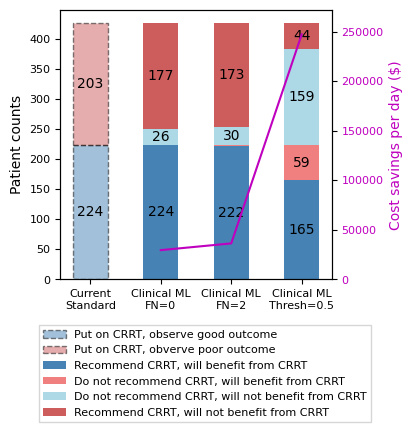

Clinical impact_all_CEDARS


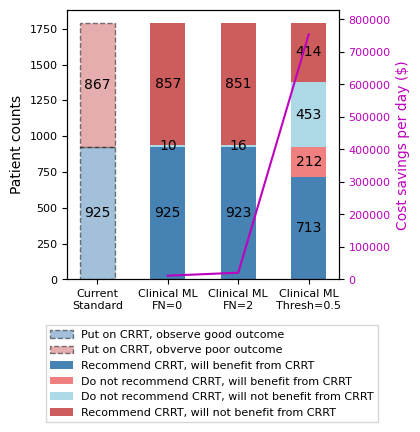

_heart
Clinical impact_heart_UCLA


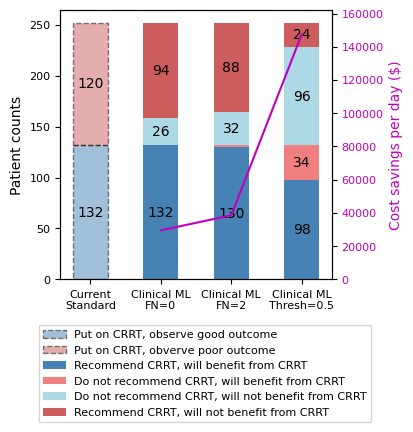

Clinical impact_heart_CEDARS


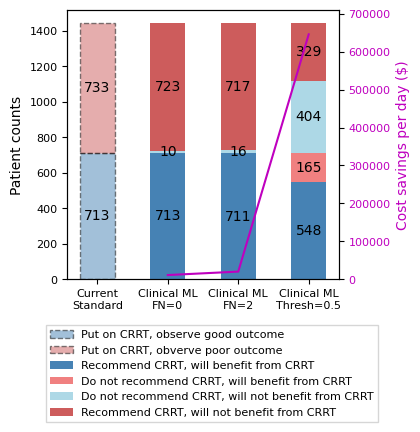

_liver
Clinical impact_liver_UCLA


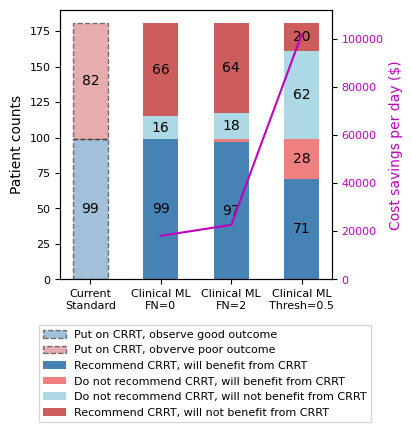

Clinical impact_liver_CEDARS


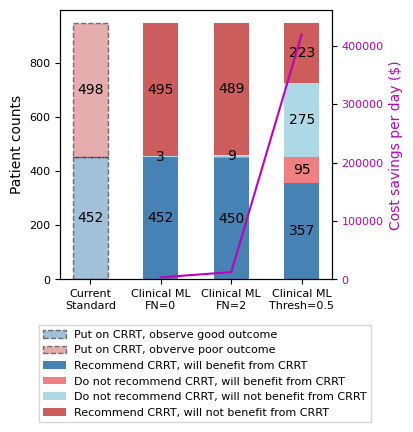

_infection
Clinical impact_infection_UCLA


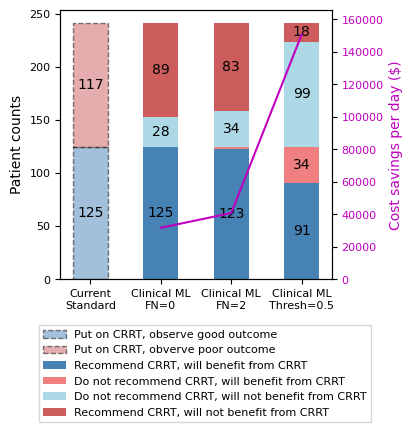

Clinical impact_infection_CEDARS


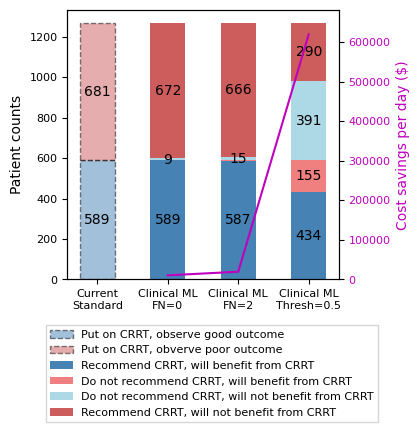

In [69]:
from models.static_models import METRIC_MAP

metric_names = ["TP", "FN", "TN","FP"]
metric_fns = [METRIC_MAP[metric] for metric in metric_names]

plt_labels = ['UCLA', "CEDARS"]
runs = [ucla_train, ucla_train]
filters = ['', 'cedars_crrt']
subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]

colors = ['steelblue','lightcoral','lightblue','indianred']
conf_matrix_label = ['Recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will not benefit from CRRT','Recommend CRRT, will not benefit from CRRT']
conf_matrix_baseline_label = ['Put on CRRT, observe good outcome','','','Put on CRRT, obverve poor outcome']

plot_clinical_impact(metric_names, metric_fns,
                     runs, filters, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label)

# Randomness

In [ ]:
def plot_randomness(run, filter):
        run, exp_path = get_run_from_name(mlflow_path, run, filter=f"tags.mlflow.runName='{run} // eval best'")
        df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts',"xgb_test__dist_comparison_table.csv"))

        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp_true = df_fntp[df_fntp['Reject H0']==True]
        df_fntp_true_var = df_fntp_true['Unnamed: 1']
        print(df_fntp_true['Reject H0'].value_counts())

        df_fntn = df[df['Unnamed: 0']=='fn_vs_tn']
        df_fntn_shared = df_fntn[df_fntn['Unnamed: 1'].isin(df_fntp_true_var)]
        print(df_fntn_shared['Reject H0'].value_counts())
        df_fntn_shared_false = df_fntn_shared[df_fntn_shared['Reject H0']==False]['Unnamed: 1']
        df_fntn_shared_true = df_fntn_shared[df_fntn_shared['Reject H0']==True]['Unnamed: 1']

        plt.figure(figsize=(4,4))
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'], bins=40, range=(0,2), 
                label=f"Similar to TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'])})")
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'], bins=40, range=(0,2),
                label=f"Different from TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'])})")
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,60])
        plt.legend()
        plt.savefig('./posthoc/randomness_fn.svg', format='svg',  bbox_inches="tight")

        plt.figure(figsize=(4.5,4))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4)
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.05])
        plt.savefig('./posthoc/randomness_fn_feat.svg', format='svg',  bbox_inches="tight")


        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[df_fptn['Reject H0']==True]
        df_fptn_true_var = df_fptn_true['Unnamed: 1']
        print(df_fptn_true['Reject H0'].value_counts())

        df_fptp = df[df['Unnamed: 0']=='fp_vs_tp']
        df_fptp_shared = df_fptp[df_fptp['Unnamed: 1'].isin(df_fptn_true_var)]
        print(df_fptp_shared['Reject H0'].value_counts())
        df_fptp_shared_false = df_fptp_shared[df_fptp_shared['Reject H0']==False]['Unnamed: 1']
        df_fptp_shared_true = df_fptp_shared[df_fptp_shared['Reject H0']==True]['Unnamed: 1']

        plt.figure(figsize=(4,4))
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'], bins=40, range=(0,2),
                label=f"Similar to TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'])})")
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'], bins=40, range=(0,2),
                label=f"Different from TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'])})")
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,60])
        plt.legend()
        plt.savefig('./posthoc/randomness_fp.svg', format='svg',  bbox_inches="tight")

        plt.figure(figsize=(4.5,4))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4)
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.05])
        plt.savefig('./posthoc/randomness_fp_feat.svg', format='svg',  bbox_inches="tight")


In [ ]:
plot_randomness(ucla_train, '')

# Bias Analysis

In [ ]:
import seaborn as sns

In [39]:
def bias_analysis(runs, filters,
                    subgroup_labels,):
    
    metric_names = ['specificity']#,'TP','TN','FP','FN', 'recall', 
    for run, filter in zip(runs, filters):

        metric_table = {}
        ci_low_table = {}
        ci_high_table = {}

        good_labels = []
        for metric_name in metric_names:
        
            metric_table[metric_name] = []
            ci_low_table[metric_name] = []
            ci_high_table[metric_name] = []
            
            with open(f'./posthoc/{run}_{filter}_subgroups.pkl', 'rb') as f:
                table = pickle.load(f)
            
            
            for subgroup_label in subgroup_labels:
                if float(table['counts'][subgroup_label].split(' (')[0]) < 5:
                    continue
                
                good_labels.append(subgroup_label)
                metric_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]))
                ci_low_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]) - float(table[metric_name][subgroup_label].split(' (')[-1].split('-')[0]))
                ci_high_table[metric_name].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]) - float(table[metric_name][subgroup_label].split(' (')[0]))
                
                if 'plus' in run or 'all_to_all' in run:
                    metric_table[metric_name][f'{subgroup_label} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    ci_low_table[metric_name][f'{subgroup_label} ucla_crrt'] = float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[-1].split('-')[0])
                    ci_high_table[metric_name][f'{subgroup_label} ucla_crrt'] = float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0])
                
                    metric_table[metric_name][f'{subgroup_label} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    ci_low_table[metric_name][f'{subgroup_label} cedars_crrt'] = float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[-1].split('-')[0])
                    ci_high_table[metric_name][f'{subgroup_label} cedars_crrt'] = float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0])

        metric_table = pd.DataFrame(metric_table)       
        metric_table['FPR'] = 1 - metric_table['specificity']
        ci_low_table['FPR'] = ci_low_table['specificity']
        ci_high_table['FPR'] = ci_high_table['specificity']
        metric_table['FNR'] = 1 - metric_table['recall']
        ci_low_table['FNR'] = ci_low_table['recall']
        ci_high_table['FNR'] = ci_high_table['recall']
        
        plt.figure(figsize=(21,3))
        for i in range(len(metric_table)):
            plt.subplot(1,len(metric_table),i+1)
            sns.heatmap([[int(metric_table['TP'][i]),int(metric_table['FP'][i])],
                         [int(metric_table['FN'][i]),int(metric_table['TN'][i])]], 
                                annot=True, 
                                xticklabels=['Positive', 'Negative'],
                                yticklabels=['Positive', 'Negative'])
            plt.ylabel('Prediction')
            plt.xlabel('Actual')
            plt.title(good_labels[i])
        plt.show()
        
        fig, ax = plt.subplots()
        x_pos = np.arange(len(metric_table))
        ax.bar(x_pos, metric_table['FPR'], width=0.25, yerr=[ci_high_table['FPR'], ci_low_table['FPR']],label='FPR', color=sns.color_palette('deep')[0])
        ax.bar(x_pos+0.25, metric_table['FNR'], width=0.25, yerr=[ci_high_table['FNR'], ci_low_table['FNR']], label='FNR',color=sns.color_palette('deep')[1])
        ax.set_xticks(x_pos+0.125)
        ax.set_xticklabels(good_labels, rotation=45, ha='right')
        plt.legend()
        fig.set_size_inches(10, 5)
        
            

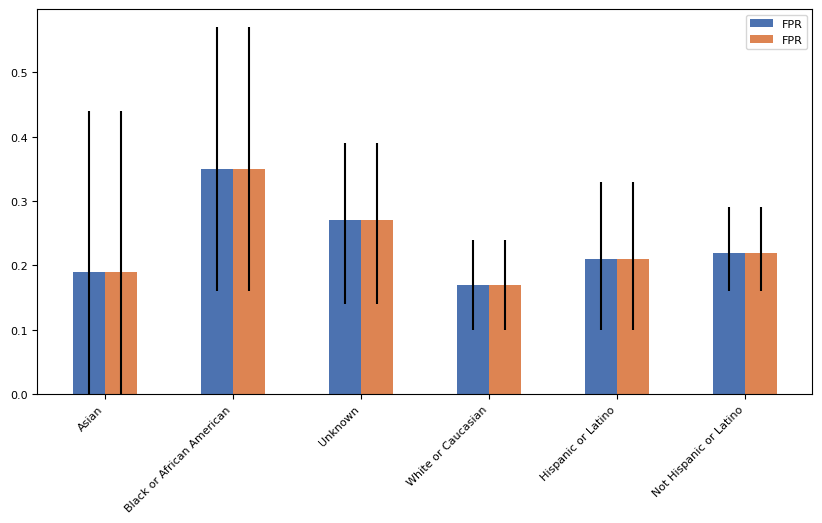

In [40]:
bias_analysis([ucla_train], [''],
                ['American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',])

In [94]:
report_as_is(['counts','TP','TN','FP','FN'],
                [ucla_train], [''],
                ['American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',])

,counts,TP,TN,FP,FN
American Indian\nor Alaska Native,2 (0%),nan (nan-nan),1.00 (0.00-2.00),1.00 (0.00-2.00),nan (nan-nan)
Asian,30 (63.3%),13.01 (8.00-18.00),8.98 (4.00-14.00),2.08 (0.00-5.00),5.93 (2.00-10.00)
Black or African American,47 (57.4%),19.86 (13.98-26.00),13.04 (7.00-19.00),7.12 (3.00-12.00),6.98 (2.00-12.00)
Native Hawaiian or\nOther Pacific Islander,3 (33.3%),nan (nan-nan),nan (nan-nan),nan (nan-nan),nan (nan-nan)
Multiple Races,4 (75.0%),nan (nan-nan),nan (nan-nan),nan (nan-nan),nan (nan-nan)
Unknown,112 (56.2%),50.19 (40.00-61.00),35.98 (27.00-46.00),13.01 (7.00-20.00),12.83 (7.00-20.00)
White or Caucasian,229 (48.5%),78.89 (65.00-93.00),97.91 (83.00-113.02),20.12 (12.00-30.00),32.08 (22.00-43.00)
Hispanic or Latino,135 (60.7%),65.92 (54.00-77.00),42.02 (31.98-52.02),11.02 (5.00-18.00),16.04 (9.00-24.00)
Not Hispanic or Latino,292 (48.6%),98.95 (83.00-115.00),117.61 (102.00-135.00),33.18 (23.00-44.00),42.26 (31.00-54.00)


# Split counts

In [53]:
def get_split_count(
              run_names, filters,):
    
    table = {'train': {},
             'val': {},
             'test': {},
             'percent': {}}
    
    for run_name, filter in zip(run_names, filters):
        
        if len(filter) > 0:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

        prefix = f"{run.data.tags['modeln']}_test"
        labels_path = join(exp_path, run.info.run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
        labels = pickle.load(open(labels_path, 'rb'))
        # test_size = len(labels.index.get_level_values('IP_PATIENT_ID').unique())
        test_size = len(labels)

        try:
            best_run = run.data.tags['best_run_id']
        except:
            best_run = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
        client_path = join(mlflow_path, run_name, 'mlruns')
        client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
        best_run = client.get_run(best_run)
        
        split_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "split_ids.pkl")
        splits = pickle.load(open(split_path, 'rb'))
        
        # assert test_size == len(splits['test'])
        
        table['train'][f'{run_name} {filter}']=len(splits['train'])
        table['val'][f'{run_name} {filter}']=len(splits['val'])
        table['test'][f'{run_name} {filter}']=test_size
        table['percent'][f'{run_name} {filter}']=labels.value_counts()[1]/test_size*100

    display(pd.DataFrame(table))

In [ ]:
runs = [
        ucla_train,
        # ucla_train,
        # ucla_train,
        cedars_train,
        # cedars_train,
        # cedars_train,
        uclapluscedars_train,
        # uclapluscedars_train,
        all_train
        ]
filters = [
        '',
        # 'cedars_crrt',
        # 'ucla_control',
        '',
        # 'ucla_crrt',
        # 'ucla_control',
        '',
        # 'ucla_control',
        ''
        ]
get_split_count(runs,filters)